<a href="https://colab.research.google.com/github/belovelace/Machine_learning_class/blob/main/Activity_CBAM_CNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [124]:

# 파일 가져오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
TRAIN = "train/"
TEST = "test/"

DATASET_PATH = "/content/drive/MyDrive/AI_study/human activity/UCI HAR Dataset/UCI HAR Dataset/"

In [126]:
def load_dataset(dataset_path, train_dir="train/", test_dir="test/"):
    # Function to load a single data file
    def load_data_file(filepath):
        return np.loadtxt(filepath)

    # Function to load X data (features) from Inertial Signals
    def load_X(path):
        signals = []
        # These are the 9 inertial signals (3-axis acc, 3-axis gyro, 3-axis total acc)
        signal_names = ['body_acc_x', 'body_acc_y', 'body_acc_z',
                        'body_gyro_x', 'body_gyro_y', 'body_gyro_z',
                        'total_acc_x', 'total_acc_y', 'total_acc_z']

        for signal_name in signal_names:
            filename = f'{signal_name}_{path.split("/")[-2]}.txt'
            filepath = os.path.join(path, "Inertial Signals", filename)
            signals.append(load_data_file(filepath))

        # Stack them to get a 3D array: (num_samples, time_steps, num_features)
        # Each signal file is (num_samples, 128)
        # Stacking along axis=-1 results in (num_samples, 128, 9)
        return np.stack(signals, axis=-1)

    # Function to load y data (labels)
    def load_y(path):
        filepath = os.path.join(path, "y_" + path.split('/')[-2] + ".txt")
        return load_data_file(filepath)

    # Load training data
    train_path = os.path.join(dataset_path, train_dir)
    trainX = load_X(train_path)
    trainy = load_y(train_path)

    # Load test data
    test_path = os.path.join(dataset_path, test_dir)
    testX = load_X(test_path)
    testy = load_y(test_path)

    return trainX, trainy, testX, testy

df = load_dataset(DATASET_PATH)

In [127]:
# Convert NumPy arrays in the tuple to pandas DataFrames for better visualization
trainX_df = pd.DataFrame(df[0].reshape(-1, df[0].shape[-1]))
trainy_df = pd.DataFrame(df[1])
testX_df = pd.DataFrame(df[2].reshape(-1, df[2].shape[-1]))
testy_df = pd.DataFrame(df[3])

# Define a mapping from numerical labels to activity names
activity_labels = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

print("Training Data (X):")
display(trainX_df.head())

print("\nTraining Labels (y):")
# Map numerical labels to activity names for display
display(trainy_df.head().replace(activity_labels))

print("\nTesting Data (X):")
display(testX_df.head())

print("\nTesting Labels (y):")
# Map numerical labels to activity names for display
display(testy_df.head().replace(activity_labels))

Training Data (X):


,0,1,2,3,4,5,6,7,8
0,0.000181,0.010767,0.055561,0.030191,0.066014,0.022859,1.012817,-0.123217,0.102934
1,0.010139,0.006579,0.055125,0.043711,0.042699,0.010316,1.022833,-0.126876,0.105687
2,0.009276,0.008929,0.048405,0.035688,0.074850,0.013250,1.022028,-0.124004,0.102102
3,0.005066,0.007489,0.049775,0.040402,0.057320,0.017751,1.017877,-0.124928,0.106553
4,0.010810,0.006141,0.043013,0.047097,0.052343,0.002553,1.023680,-0.125767,0.102814



Training Labels (y):


,0
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING



Testing Data (X):


,0,1,2,3,4,5,6,7,8
0,0.011653,-0.029399,0.106826,0.437464,0.531349,0.136528,1.041216,-0.269796,0.023780
1,0.013109,-0.039729,0.152455,0.468264,0.721069,0.097622,1.041803,-0.280025,0.076293
2,0.011269,-0.052406,0.216846,0.498257,0.520328,0.083556,1.039086,-0.292663,0.147475
3,0.027831,-0.052106,0.202581,0.479396,0.372625,0.022861,1.054768,-0.292384,0.139906
4,0.002318,-0.045470,0.176010,0.389894,0.414541,-0.025939,1.028376,-0.285826,0.119934



Testing Labels (y):


,0
0,STANDING
1,STANDING
2,STANDING
3,STANDING
4,STANDING


In [128]:
# 실제 라벨 값들 확인
print("Training labels unique values:", np.unique(df[1]))
print("Testing labels unique values:", np.unique(df[3]))
print("Training labels shape:", df[1].shape)
print("Testing labels shape:", df[3].shape)

Training labels unique values: [1. 2. 3. 4. 5. 6.]
Testing labels unique values: [1. 2. 3. 4. 5. 6.]
Training labels shape: (7352,)
Testing labels shape: (2947,)


# CBAM
https://ffighting.net/deep-learning-paper-review/vision-model/cbam/

BAM은 SENet이 Channel Attention만 사용하고 있는 점을 문제로 지적했죠. 이렇게 되면 ‘무엇’에 집중할 수는 있지만, ‘어디에’는 집중할 수 없다는 점을 파고들어 Channel Attention과 Spatial Attention을 모두 적용하였습니다. CBAM은 이름에서도 알 수 있듯 BAM의 철학을 계승하여 발전시킨 모델이라고 할 수 있습니다.
- Channel Attention 모듈과 Spatial Attention 모듈을 직렬로 연결

In [129]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [130]:
class CBAM1D(layers.Layer):
    def __init__(self, channels, reduction=16, **kwargs):
        super(CBAM1D, self).__init__(**kwargs)
        self.channels = channels
        self.reduction = max(1, reduction)  # reduction이 0이 되지 않도록

        # Channel Attention
        self.global_avg_pool = layers.GlobalAveragePooling1D()
        self.global_max_pool = layers.GlobalMaxPooling1D()

        self.mlp = keras.Sequential([
            layers.Dense(max(1, channels // self.reduction), activation='relu'),  # 최소 1
            layers.Dense(channels, activation=None)
        ])

        # Spatial Attention
        self.spatial_conv = layers.Conv1D(
            filters=1,
            kernel_size=7,
            padding='same',
            activation='sigmoid',
            use_bias=False
        )

    def call(self, inputs):
        # Channel Attention
        avg_pool = self.global_avg_pool(inputs)
        max_pool = self.global_max_pool(inputs)

        avg_out = self.mlp(avg_pool)
        max_out = self.mlp(max_pool)

        # 수치 안정성을 위한 클리핑
        channel_attention = tf.nn.sigmoid(tf.clip_by_value(avg_out + max_out, -10, 10))
        channel_attention = tf.expand_dims(channel_attention, axis=1)

        channel_refined = inputs * channel_attention

        # Spatial Attention
        avg_pool_spatial = tf.reduce_mean(channel_refined, axis=2, keepdims=True)
        max_pool_spatial = tf.reduce_max(channel_refined, axis=2, keepdims=True)

        spatial_concat = tf.concat([avg_pool_spatial, max_pool_spatial], axis=2)
        spatial_attention = self.spatial_conv(spatial_concat)

        output = channel_refined * spatial_attention

        return output

In [131]:
class Conv1DBlock(layers.Layer):
    def __init__(self, filters, kernel_size=3, use_cbam=True, dropout_rate=0.5, **kwargs):
        super(Conv1DBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.use_cbam = use_cbam
        self.dropout_rate = dropout_rate

        # 가중치 초기화 개선
        self.conv1d = layers.Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            padding='same',
            activation=None,
            use_bias=False,
            kernel_initializer='he_normal'  # 추가
        )

        self.batch_norm = layers.BatchNormalization()

        if self.use_cbam:
            self.cbam = CBAM1D(channels=filters)

        self.activation = layers.ReLU()
        self.max_pool = layers.MaxPooling1D(pool_size=2)
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, inputs, training=None):
        x = self.conv1d(inputs)
        x = self.batch_norm(x, training=training)

        # 배치 정규화 후 값 체크 (선택사항)
        x = tf.clip_by_value(x, -100, 100)  # 극단적 값 방지

        x = self.activation(x)

        if self.use_cbam:
            x = self.cbam(x)

        x = self.max_pool(x)
        x = self.dropout(x, training=training)

        return x

In [132]:
def create_cbam_cnn_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape, name='input_sensor_data')

    x = layers.Reshape((input_shape[0], 1))(inputs)

    # Conv Block 1 - 더 보수적인 설정
    x = Conv1DBlock(filters=64, kernel_size=5, dropout_rate=0.3)(x)  # 드롭아웃 낮춤

    # Conv Block 2
    x = Conv1DBlock(filters=128, kernel_size=5, dropout_rate=0.4)(x)  # 드롭아웃 낮춤

    # Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # 더 안정적인 분류기
    x = layers.Dense(64,
                    activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.01),  # L2 정규화 약하게
                    kernel_initializer='he_normal')(x)  # 초기화 개선
    x = layers.Dropout(0.5)(x)  # 드롭아웃 낮춤

    # 출력층에도 안정적 초기화
    outputs = layers.Dense(num_classes,
                          activation='softmax',
                          kernel_initializer='glorot_uniform')(x)

    model = keras.Model(inputs, outputs, name='Simple_CBAM_CNN_HAR')

    return model

In [133]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [134]:
# 데이터 로드 함수
def load_uci_har_data():
    print("UCI HAR 데이터 로드 중...")

    # 훈련 데이터 로드
    train_path = DATASET_PATH + TRAIN
    X_train = np.loadtxt(train_path + "X_train.txt")
    y_train = np.loadtxt(train_path + "y_train.txt")

    # 테스트 데이터 로드
    test_path = DATASET_PATH + TEST
    X_test = np.loadtxt(test_path + "X_test.txt")
    y_test = np.loadtxt(test_path + "y_test.txt")

    print(f"훈련 데이터: {X_train.shape}")
    print(f"테스트 데이터: {X_test.shape}")
    print(f"훈련 레이블: {y_train.shape}")
    print(f"테스트 레이블: {y_test.shape}")

    return X_train, X_test, y_train, y_test

In [135]:
# 데이터 전처리 함수
def preprocess_data(X_train, X_test, y_train, y_test):
    print("데이터 전처리 중...")

    # 특성 정규화
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 레이블을 0부터 시작하도록 변경 (1-6 -> 0-5)
    y_train_indexed = y_train - 1
    y_test_indexed = y_test - 1

    # 원핫 인코딩
    num_classes = 6
    y_train_onehot = tf.keras.utils.to_categorical(y_train_indexed, num_classes)
    y_test_onehot = tf.keras.utils.to_categorical(y_test_indexed, num_classes)

    print(f"정규화된 훈련 데이터: {X_train_scaled.shape}")
    print(f"정규화된 테스트 데이터: {X_test_scaled.shape}")
    print(f"원핫 인코딩된 훈련 레이블: {y_train_onehot.shape}")
    print(f"원핫 인코딩된 테스트 레이블: {y_test_onehot.shape}")

    return X_train_scaled, X_test_scaled, y_train_onehot, y_test_onehot, scaler, num_classes

# 데이터 로드
X_train, X_test, y_train, y_test = load_uci_har_data()

# 데이터 전처리
X_train_scaled, X_test_scaled, y_train_onehot, y_test_onehot, scaler, num_classes = preprocess_data(X_train, X_test, y_train, y_test)

UCI HAR 데이터 로드 중...
훈련 데이터: (7352, 561)
테스트 데이터: (2947, 561)
훈련 레이블: (7352,)
테스트 레이블: (2947,)
데이터 전처리 중...
정규화된 훈련 데이터: (7352, 561)
정규화된 테스트 데이터: (2947, 561)
원핫 인코딩된 훈련 레이블: (7352, 6)
원핫 인코딩된 테스트 레이블: (2947, 6)


In [136]:
# 1. 모델을 완전히 새로 만들기
model = create_cbam_cnn_model(input_shape, num_classes)

# 2. 균형 잡힌 보수적 설정 - clipnorm을 옵티마이저로 이동
model.compile(
    optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),  # clipnorm을 여기로
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 3. 데이터 확인 (nan이 있는지)
print("X_train에 nan 있나?", np.isnan(X_train).any())
print("y_train에 nan 있나?", np.isnan(y_train).any())
print("X_train 범위:", X_train.min(), "~", X_train.max())
print("y_train 범위:", y_train.min(), "~", y_train.max())

# 레이블을 0-5 범위로 변환
y_train_corrected = y_train - 1
print("수정된 y_train 범위:", y_train_corrected.min(), "~", y_train_corrected.max())

# 다시 학습
history = model.fit(
    X_train, y_train_corrected,  # 수정된 레이블 사용
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

X_train에 nan 있나? False
y_train에 nan 있나? False
X_train 범위: -1.0 ~ 1.0
y_train 범위: 1.0 ~ 6.0
수정된 y_train 범위: 0.0 ~ 5.0
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 121ms/step - accuracy: 0.2884 - loss: 2.8337 - val_accuracy: 0.3385 - val_loss: 2.4539
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3663 - loss: 1.9968 - val_accuracy: 0.3195 - val_loss: 2.0440
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5027 - loss: 1.5185 - val_accuracy: 0.6213 - val_loss: 1.6197
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6596 - loss: 1.0914 - val_accuracy: 0.6669 - val_loss: 1.2039
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7040 - loss: 0.8978 - val_accuracy: 0.7192 - val_loss: 0.9354
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7429 - loss: 0.7858 - val_accuracy: 0.7865 - val_loss: 0.7252
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7732 - loss: 0.6936 - val_accuracy: 0.7621 - val_loss: 0.686

사용 가능한 키: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


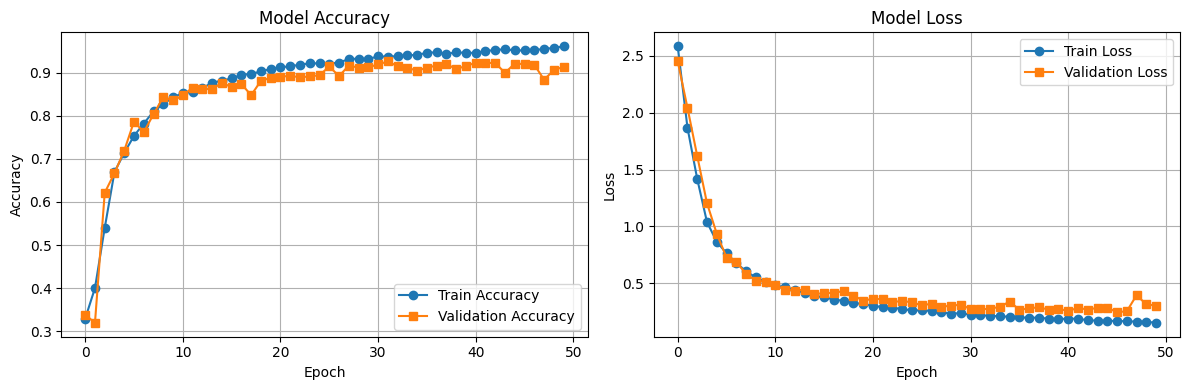

In [138]:
# 학습 결과 시각화 (수정된 버전)
def plot_training_history(history):
    # history 키 확인
    print("사용 가능한 키:", list(history.history.keys()))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # 정확도 - 올바른 키 이름 사용
    axes[0].plot(history.history['accuracy'], 'o-', label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], 's-', label='Validation Accuracy')
    axes[0].set_title('Model Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # 손실
    axes[1].plot(history.history['loss'], 'o-', label='Train Loss')
    axes[1].plot(history.history['val_loss'], 's-', label='Validation Loss')
    axes[1].set_title('Model Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [140]:
# 테스트 정확도 계산
predictions = model.predict(X_test, verbose=0)
predicted_classes = np.argmax(predictions, axis=1)

# y_test도 0-5 범위로 변환
y_test_corrected = y_test - 1

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_corrected, predicted_classes)

# 손실 계산 (근사치)
from sklearn.metrics import log_loss
try:
    loss = log_loss(y_test_corrected, predictions)
except:
    loss = 0.0  # 계산 실패 시

print("="*50)
print("           테스트 결과")
print("="*50)
print(f"테스트 데이터 정확도 (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"테스트 데이터 손실 (Loss): {loss:.4f}")
print("="*50)

           테스트 결과
테스트 데이터 정확도 (Accuracy): 0.8806 (88.06%)
테스트 데이터 손실 (Loss): 0.3509


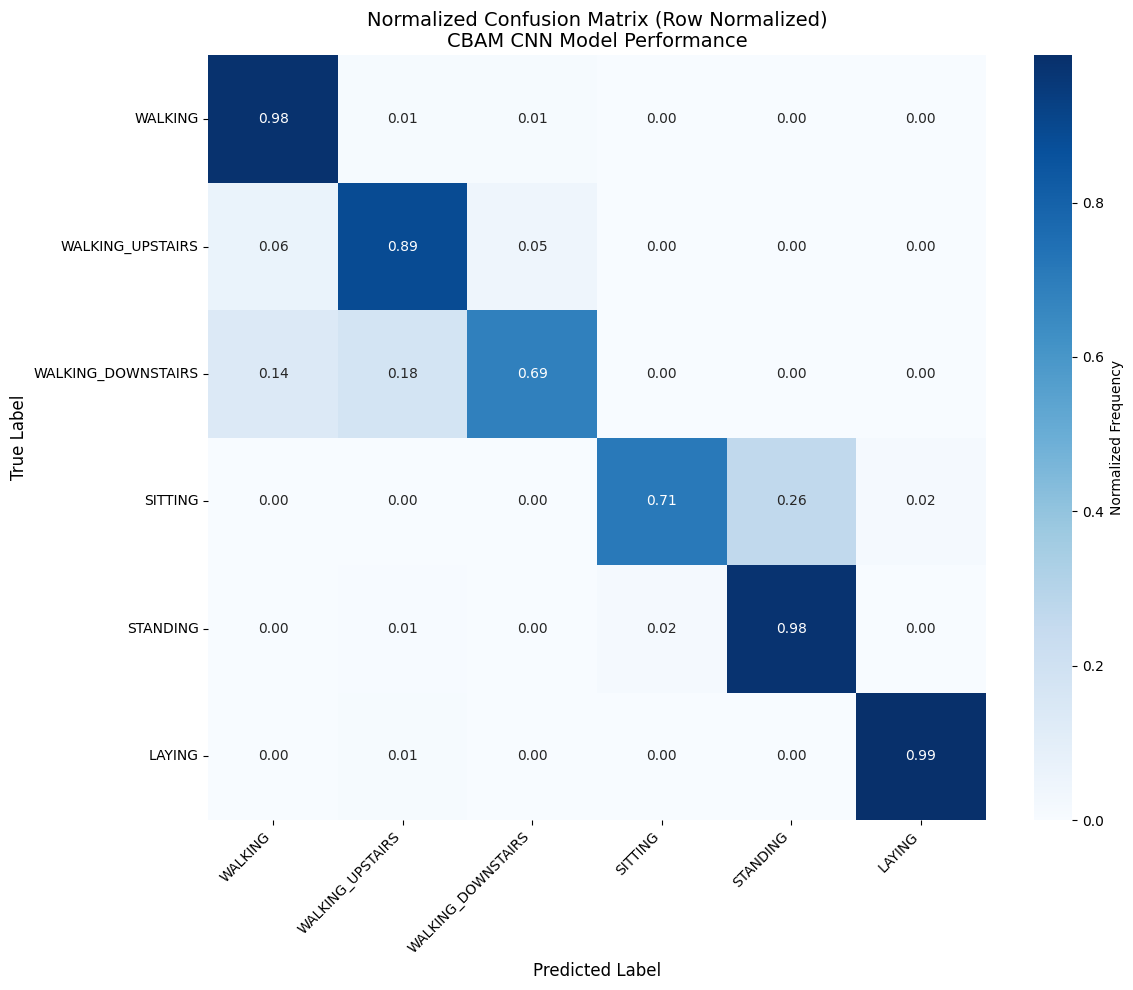


실제 혼동 행렬 (개수):
                    WALKING  WALKING_UPSTAIRS  WALKING_DOWNSTAIRS  SITTING  \
WALKING                 486                 5                   5        0   
WALKING_UPSTAIRS         30               419                  22        0   
WALKING_DOWNSTAIRS       57                75                 288        0   
SITTING                   0                 1                   0      351   
STANDING                  0                 3                   0       10   
LAYING                    0                 5                   0        0   

                    STANDING  LAYING  
WALKING                    0       0  
WALKING_UPSTAIRS           0       0  
WALKING_DOWNSTAIRS         0       0  
SITTING                  130       9  
STANDING                 519       0  
LAYING                     0     532  


In [141]:
# 라벨 정의
LABELS = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']

# 혼동 행렬 계산
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test_corrected, predicted_classes)

# 혼동 행렬 정규화 (각 행의 합으로 나누어 비율로 변환)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# 정규화된 혼동 행렬 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=LABELS,
    yticklabels=LABELS,
    cbar_kws={'label': 'Normalized Frequency'}
)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Normalized Confusion Matrix (Row Normalized)\nCBAM CNN Model Performance', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 추가: 실제 개수도 표시
print("\n실제 혼동 행렬 (개수):")
print("="*50)
conf_df = pd.DataFrame(conf_matrix, index=LABELS, columns=LABELS)
print(conf_df)